# MobileNet

In [1]:
#import the required Libraries

import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


In [2]:
#Links to the image dataset and the metadata csv

img_link ='dataverse_files/HAM10000_images'
csv_link = 'dataverse_files/HAM10000_metadata.csv'

In [3]:
# load, resize and process images  and map the class labels from metadata

metadata = pd.read_csv(csv_link)
labels = metadata['dx']
images = []
for img_id in metadata['image_id']:
    img_path = os.path.join(img_link, img_id+'.jpg')
    image = cv2.imread(img_path)
    image = cv2.resize(image, (128, 128))
    images.append(image)
X = np.array(images)
y = to_categorical(labels.factorize()[0], num_classes=7)

In [4]:
#split train and test data to 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
input_shape = (128, 128, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)


In [7]:
model = Model(inputs=base_model.input, outputs=output)

#compile model and configure Early stopping
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


In [8]:
#fit and train model for 50 epochs
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
model.save('model.h5')

Epoch 1/50
251/251 [==============================] - 205s 797ms/step - loss: 1.1123 - accuracy: 0.6419 - val_loss: 2.5250 - val_accuracy: 0.6680
Epoch 2/50
251/251 [==============================] - 209s 831ms/step - loss: 0.8493 - accuracy: 0.6937 - val_loss: 2.5626 - val_accuracy: 0.6680
Epoch 3/50
251/251 [==============================] - 203s 809ms/step - loss: 0.7068 - accuracy: 0.7410 - val_loss: 2.1674 - val_accuracy: 0.6690
Epoch 4/50
251/251 [==============================] - 198s 791ms/step - loss: 0.5958 - accuracy: 0.7857 - val_loss: 1.3526 - val_accuracy: 0.6935
Epoch 5/50
251/251 [==============================] - 198s 789ms/step - loss: 0.4770 - accuracy: 0.8315 - val_loss: 0.8301 - val_accuracy: 0.7254
Epoch 6/50
251/251 [==============================] - 198s 791ms/step - loss: 0.3878 - accuracy: 0.8648 - val_loss: 0.7672 - val_accuracy: 0.7509
Epoch 7/50
251/251 [==============================] - 198s 789ms/step - loss: 0.2993 - accuracy: 0.8973 - val_loss: 0.9048 -

In [10]:
#calculate accuracy, F-1 score, Precision, Recall and confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
confusion_mat = confusion_matrix(y_true, y_pred)
print('Test accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Confusion matrix:', confusion_mat)

63/63 [==============================] - 9s 135ms/step
Test accuracy: 0.7948077917098999
F1 score: 0.7896832622317308
Precision: 0.8276765960121745
Recall: 0.7948077883175237
Confusion matrix: [[ 186   32    0    4    0    6    0]
 [  85 1225    2   18    2    6    0]
 [  14    4    8    0    0    2    0]
 [  66   69    2   86    0    3    0]
 [   2    1    0    0   17    0    1]
 [  30   11    0    0    0   51    1]
 [  35    9    0    1    0    5   19]]


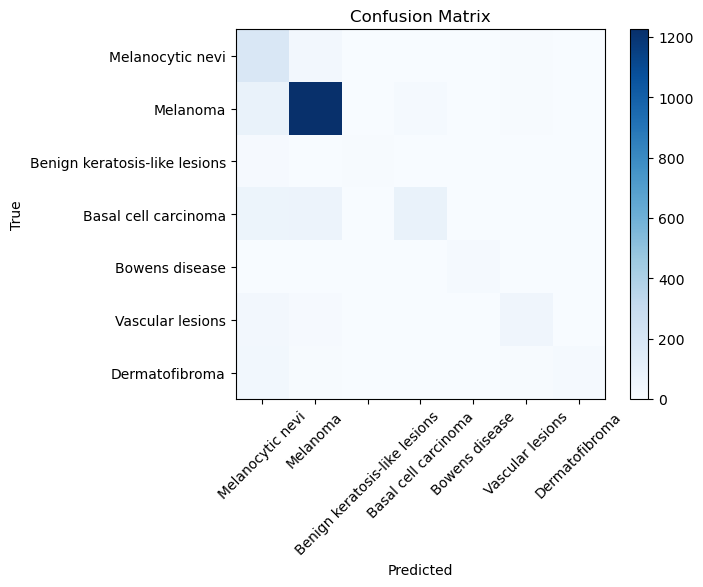

In [17]:
# Plot confusion matrix
plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

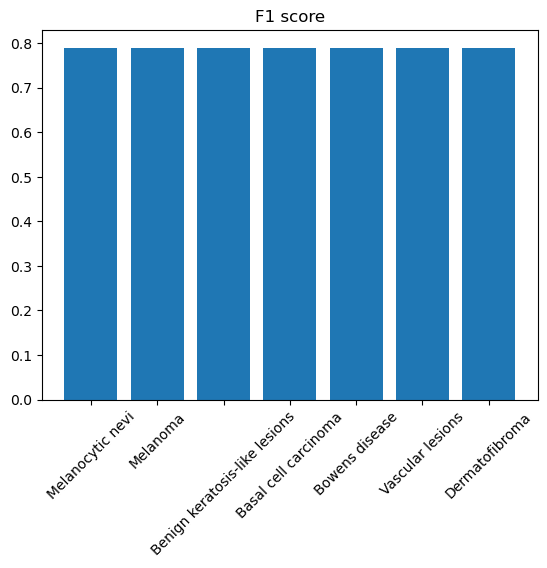

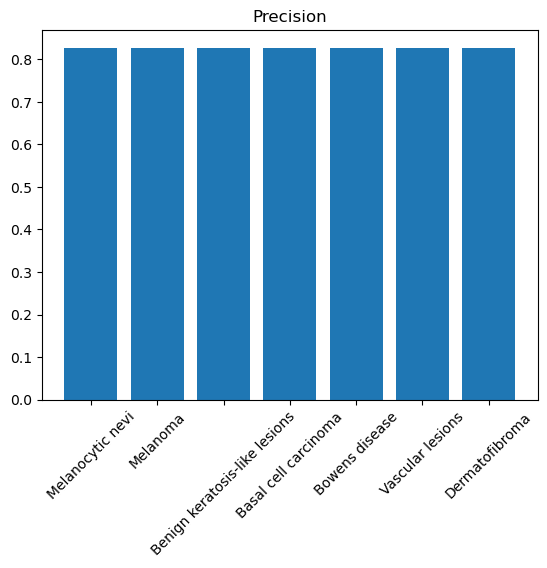

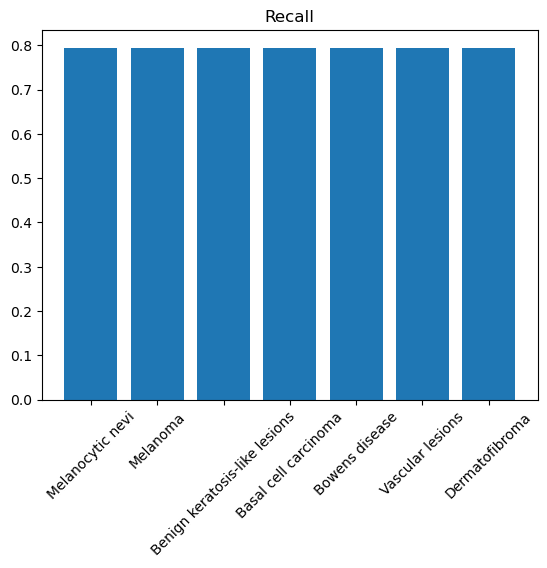

In [16]:
# Plot F1 score, precision, and recall
labels = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions', 'Basal cell carcinoma', 'Bowens disease', 'Vascular lesions', 'Dermatofibroma']
metrics = [f1, precision, recall]
metric_names = ['F1 score', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.bar(labels, metric)
    plt.title(metric_names[i])
    plt.xticks(rotation=45)
    plt.show()

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6230738162994385
Test accuracy: 0.7948077917098999
